In [1]:
#If using google colab
#from google.colab import drive
#drive.mount('/content/drive')

#from google.colab import files
#%cd "/content/drive/MyDrive/Colab Notebooks"

In [2]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
import os

In [3]:
from config import Config

In [4]:
# ['Reddit', 'iSarcasm']
cfg = Config('Reddit')
dataset = cfg.dataset
file_path = cfg.input_file_path
comment_col_name = cfg.comment_col_name
label_col_name = cfg.label_col_name

In [5]:
dataset

'Reddit'

In [6]:
file_path

'..\\data\\Reddit\\train-balanced-sarcasm.csv'

In [7]:
sarcasm_df = pd.read_table(file_path, sep = ",", index_col=False)

In [8]:
sarcasm_df.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [9]:
##Also adding test data
##If you want to use test data, use this block otherwise, comment it out
if dataset == "Reddit":
    test_data = pd.read_csv(cfg.test_file_path, sep = "\t", index_col=False, names = sarcasm_df.columns )
elif dataset == "iSarcasmEval":
    test_data = pd.read_csv(cfg.test_file_path, sep = ",", index_col=False)
sarcasm_total_data = [sarcasm_df, test_data]
sarcasm_df = pd.concat(sarcasm_total_data)

In [10]:
test_data

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,Your mom,Ronan3463,teenagers,1,-1,-1,2017-04,1491694828,What are you doing 3 hours from now?
1,0,"I'm curious, how much for the White Photons?",NCJoe97,RocketLeagueExchange,1,-1,-1,2017-02,1487092935,"Painted Exotics, wheels, Toppers and more Pain..."
2,0,Khloe Kardashian effect,grpocz,nba,1,-1,-1,2017-03,1489376837,That was some of the worst defensive reboundin...
3,0,Knowledge is power!,Wolfy_McDerpbutt,darksouls3,1,-1,-1,2017-02,1485992580,almost 400 hours in and I thought you were jus...
4,0,Get the Prussians (Germans) to pay for a statu...,Warthog_A-10,ireland,1,-1,-1,2017-02,1486081980,I wouldn't mind if we got a bit keener about o...
...,...,...,...,...,...,...,...,...,...,...
283329,1,"Damn those oil fairies, why do they keep steal...",M0b1u5,Economics,0,0,0,2009-06,1244700266,World oil reserves fall for first time in decade
283330,1,Religion must have the answer,Reedzit,science,3,3,0,2009-02,1233605181,I've been searching for the answer for this fo...
283331,1,oh I thought they were cursing coz they liked ...,darwin_wins,funny,-5,-5,0,2009-02,1235619258,They hated it
283332,1,My B-52 bombers are in the shop under repair o...,DonnieMarco,reddit.com,2,2,0,2009-04,1239005246,"Humans get tortured at Guantanamo, you make a ..."


## Data Analysis

In [11]:
sarcasm_df.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [12]:
# Data Pre-Processing
# Removing the null comments

sarcasm_df.dropna(subset=[comment_col_name], inplace=True)
sarcasm_df[comment_col_name] = sarcasm_df[comment_col_name].str.lower()
sarcasm_df[comment_col_name] = sarcasm_df[comment_col_name].str.replace('[^\w\s]','')

C:\Users\Urvashi\AppData\Local\Temp\ipykernel_6876\1140158327.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  sarcasm_df[comment_col_name] = sarcasm_df[comment_col_name].str.replace('[^\w\s]','')


In [13]:
# Converting the timestamp into DateTime object
#sarcasm_df.created_utc = pd.to_datetime(sarcasm_df.created_utc)
#sarcasm_df.info()

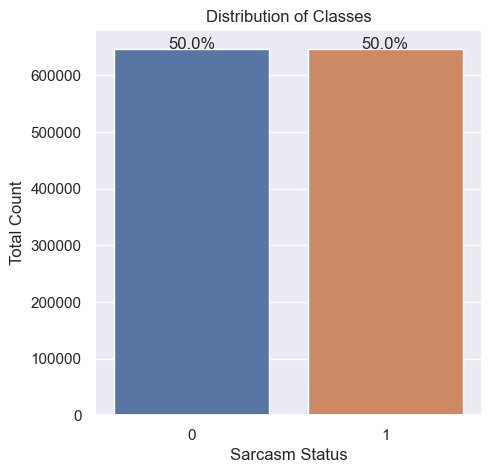

In [14]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x=label_col_name,  data= sarcasm_df) 
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
           height + 3,
           '{:1.1f}%'.format((height/total)*100),
            ha="center") 
plt.show()

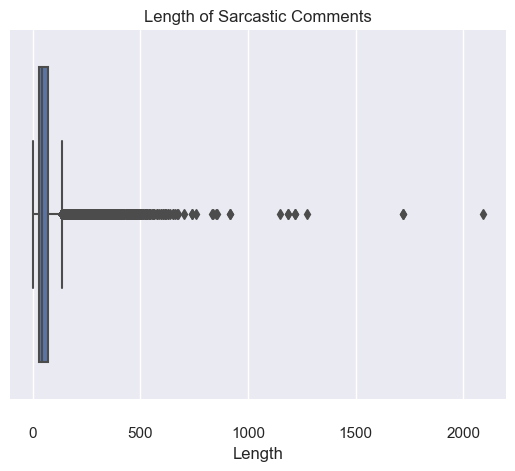

In [15]:
# Distribution of the lenth of Sarcastic comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df[label_col_name] == 1, comment_col_name].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

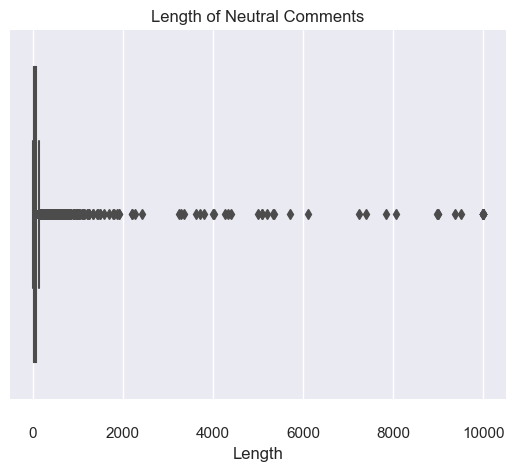

In [16]:
# Distribution of the lenth of Neutral comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df[label_col_name] == 0, comment_col_name].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

C:\Users\Urvashi\AppData\Local\Temp\ipykernel_6876\2284420690.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b= False)


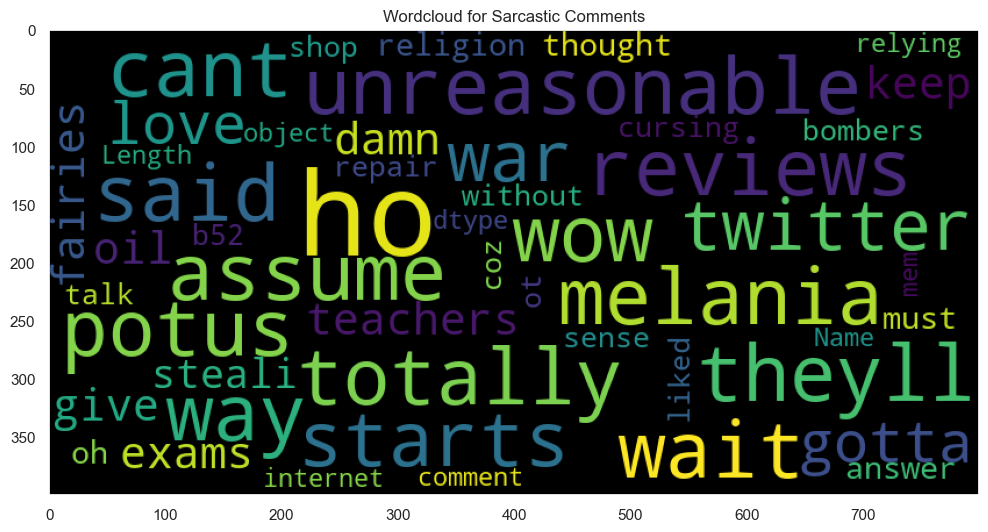

In [17]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_df.loc[sarcasm_df[label_col_name] == 1, comment_col_name]))
plt.grid(b= False)
plt.title("Wordcloud for Sarcastic Comments")
plt.imshow(wordcloud);

C:\Users\Urvashi\AppData\Local\Temp\ipykernel_6876\2827342884.py:3: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b= False)


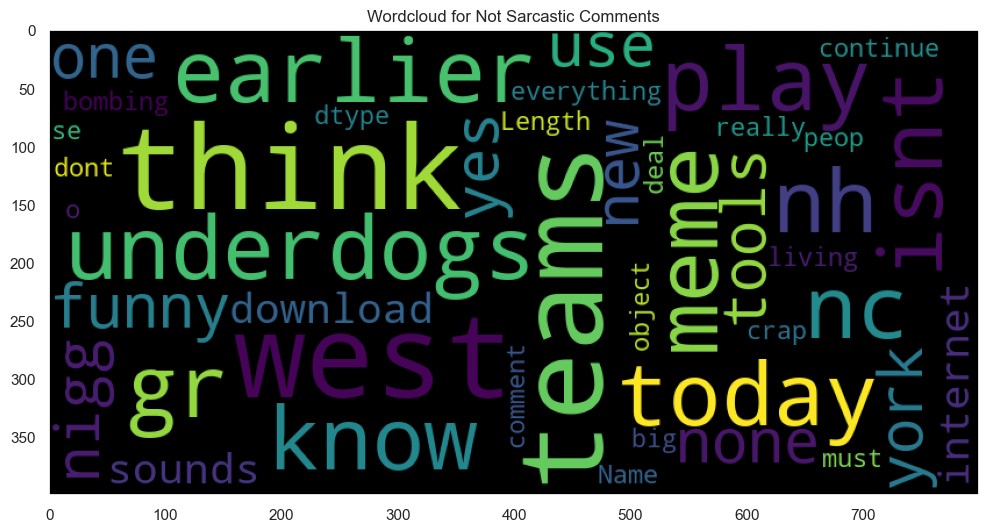

In [18]:
plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_df.loc[sarcasm_df[label_col_name] == 0, comment_col_name]))
plt.grid(b= False)
plt.title("Wordcloud for Not Sarcastic Comments")
plt.imshow(wordcloud);

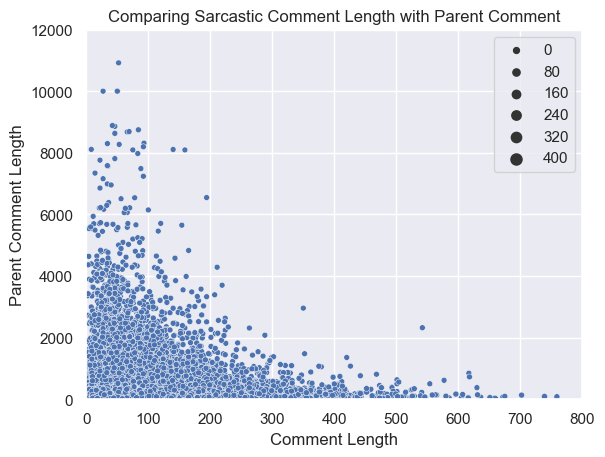

In [19]:
#Comparison of comment with its parent comment can only be done in the Reddit dataset 
if dataset == "Reddit":
    sarcasm_comm_len = np.array(sarcasm_df.loc[sarcasm_df[label_col_name] == 1][comment_col_name].str.len())
    parent_comm_len = np.array(sarcasm_df.loc[sarcasm_df[label_col_name] == 1]['parent_comment'].str.len())
    ratio_len = np.array((sarcasm_df.loc[sarcasm_df[label_col_name] == 1][comment_col_name].str.len())/(sarcasm_df.loc[sarcasm_df[label_col_name] == 1]['parent_comment'].str.len()))
    dataset_reddit = pd.DataFrame({'Comment Length': sarcasm_comm_len, 'Parent Comment Length': parent_comm_len, 'Ratio Length': ratio_len}, columns=['Comment Length', 'Parent Comment Length', 'Ratio Length'])
    ax = plt.axes()
    sns.scatterplot(data=dataset_reddit, x="Comment Length", y="Parent Comment Length",  size=ratio_len)
    ax.set_title("Comparing Sarcastic Comment Length with Parent Comment")
      # control x and y limits
    plt.ylim(0, 12000)
    plt.xlim(0, 800)
    plt.show()

C:\Users\Urvashi\AppData\Local\Temp\ipykernel_6876\1776619702.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit.sarcastic.iloc[i] = count_sarcastic
C:\Users\Urvashi\AppData\Local\Temp\ipykernel_6876\1776619702.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit.natural.iloc[i] = length - count_sarcastic
C:\Users\Urvashi\AppData\Local\Temp\ipykernel_6876\1776619702.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

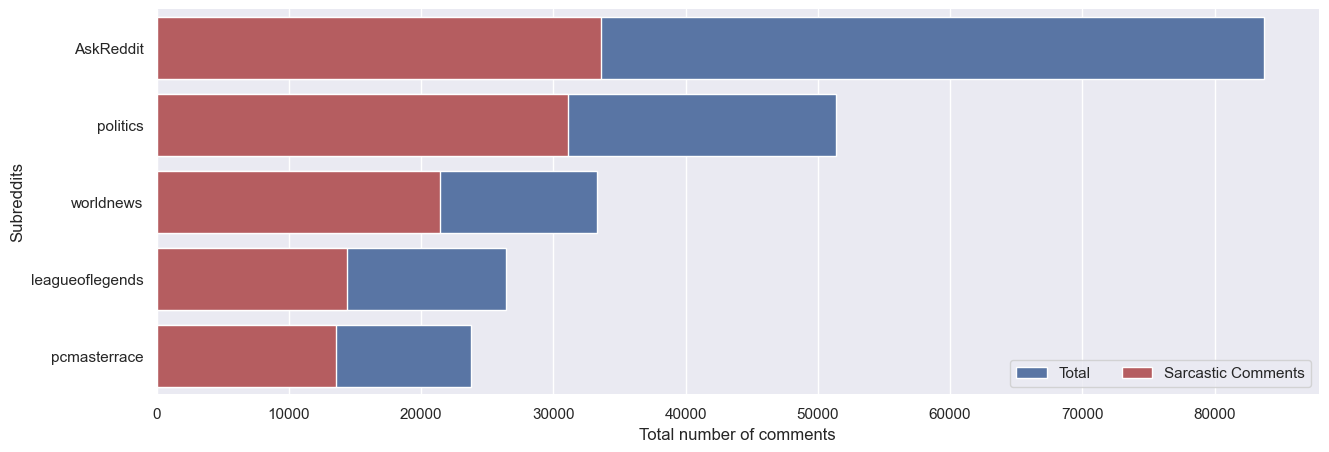

In [20]:
if dataset == "Reddit":
    top_reddits=sarcasm_df['subreddit'].value_counts()[:5].index.tolist()
    subreddit = pd.DataFrame()
    subreddit['subreddit'] = top_reddits
    subreddit['sarcastic'] = np.nan
    subreddit['natural'] = np.nan
    subreddit['total'] = np.nan
  # Calculating the count of Sarcastic and Natural comments for the top 5 subreddits 
    for i in range(len(top_reddits)):
        temp = sarcasm_df.loc[sarcasm_df['subreddit'] == subreddit.subreddit.iloc[i]]
        length = len(temp)
        count_sarcastic = len(temp.loc[temp[label_col_name] == 1])
        subreddit.sarcastic.iloc[i] = count_sarcastic
        subreddit.natural.iloc[i] = length - count_sarcastic
        subreddit.total.iloc[i] = length
        # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 5))
      
    # Plot the total comments for the subreddits
    sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")
    # Plot the total sarcastic comments for the subreddits
    sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="r")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
    sns.despine(left=True, bottom=True)

## Data Preprocessing
* Lemmatization
* Stop words removal

In [21]:
sarcasm_df.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc and nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,they were underdogs earlier today but since gr...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,this meme isnt funny none of the new york nigg...,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,i could use one of those tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,i dont pay attention to her but as long as she...,only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,trick or treating in general is just weird,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,blade masterymasamune or gtfo,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,you dont have to you have a good build buy gam...,SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,i would love to see him at lolla,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [22]:
# drop every column except label and comment itself
#sarcasm_data = sarcasm_df[[label_col_name, comment_col_name]]

#using all columns
sarcasm_data = sarcasm_df

In [23]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
#nltk.download('all')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Urvashi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Urvashi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Urvashi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Urvashi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Urvashi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
sarcasm_data.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc and nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,they were underdogs earlier today but since gr...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,this meme isnt funny none of the new york nigg...,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,i could use one of those tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,i dont pay attention to her but as long as she...,only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,trick or treating in general is just weird,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,blade masterymasamune or gtfo,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,you dont have to you have a good build buy gam...,SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,i would love to see him at lolla,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [25]:
#sarcasm_data

In [26]:
#def to_doc(words:tuple) -> spacy.tokens.Doc:
    # Create SpaCy documents by joining the words into a string
    #return nlp(' '.join(words))

#def remove_stops(doc) -> list:
    # Filter out stop words by using the `token.is_stop` attribute
    

#def lemmatize(doc) -> list:
    # Take the `token.lemma_` of each non-stop word 

def lemmatize_text(doc):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(doc)]
    #spacy alternative
    #return [j.lemma_ for token in doc for j in nlp(token)]

def remove_stops(doc) -> list:
    # Filter out stop words by using the stop_words attribute
    return [token for token in doc if token not in stop_words]
    #spacy alternative
    #return [token.text for token in doc if not token.is_stop]

In [27]:
sarcasm_data['text_lemmatized'] = sarcasm_data[comment_col_name].apply(lemmatize_text)

# apply removing stop words to all
sarcasm_data['removed_stop_words'] = sarcasm_data.text_lemmatized.apply(remove_stops)

In [28]:
sarcasm_data.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,text_lemmatized,removed_stop_words
0,0,nc and nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...","[nc, and, nh]","[nc, nh]"
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,"[you, do, know, west, team, play, against, wes...","[know, west, team, play, west, team, east, tea..."
2,0,they were underdogs earlier today but since gr...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,"[they, were, underdog, earlier, today, but, si...","[underdog, earlier, today, since, gronks, anno..."
3,0,this meme isnt funny none of the new york nigg...,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,"[this, meme, isnt, funny, none, of, the, new, ...","[meme, isnt, funny, none, new, york, nigga, one]"
4,0,i could use one of those tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,"[i, could, use, one, of, those, tool]","[could, use, one, tool]"
5,0,i dont pay attention to her but as long as she...,only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?,"[i, dont, pay, attention, to, her, but, a, lon...","[dont, pay, attention, long, shes, legal, woul..."
6,0,trick or treating in general is just weird,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...,"[trick, or, treating, in, general, is, just, w...","[trick, treating, general, weird]"
7,0,blade masterymasamune or gtfo,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...,"[blade, masterymasamune, or, gtfo]","[blade, masterymasamune, gtfo]"
8,0,you dont have to you have a good build buy gam...,SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...,"[you, dont, have, to, you, have, a, good, buil...","[dont, good, build, buy, game, save]"
9,0,i would love to see him at lolla,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...,"[i, would, love, to, see, him, at, lolla]","[would, love, see, lolla]"


## Word cloud after Preprocessing

In [29]:
sarcasm_data['stop_words_string'] = [' '.join(map(str, l)) for l in sarcasm_data['removed_stop_words']]

C:\Users\Urvashi\AppData\Local\Temp\ipykernel_6876\3176774838.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b= False)


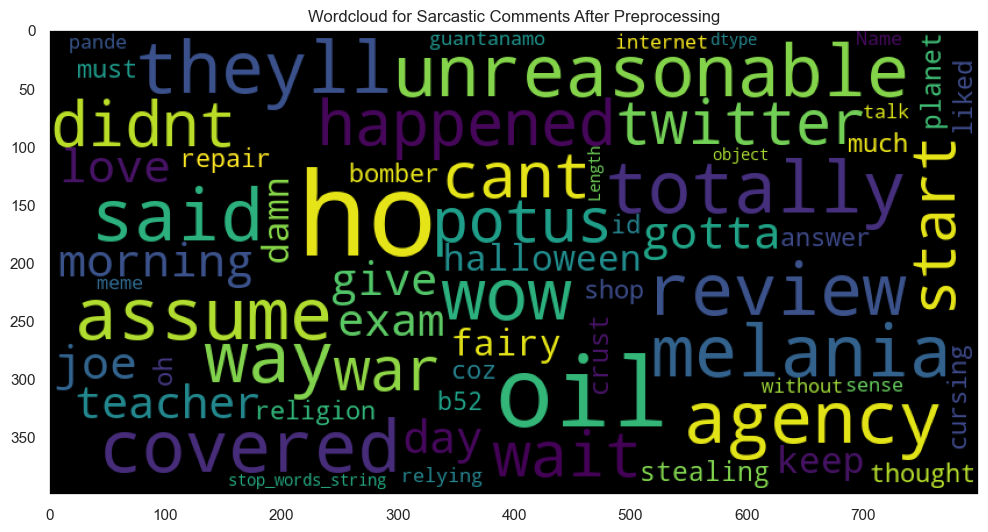

In [30]:
wordcloud = WordCloud(background_color='black',
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_data.loc[sarcasm_data[label_col_name] == 1, "stop_words_string"]))
plt.grid(b= False)
plt.title("Wordcloud for Sarcastic Comments After Preprocessing")
plt.imshow(wordcloud);

## Save the file as csv

In [31]:
cfg.preprocessed_file_path

'..\\data\\Reddit\\preprocessed-with-all_columns.csv'

In [32]:
#sarcasm_data.to_csv(cfg.preprocessed_file_path )